Questo notebook Python contiene lo svolgimento dell'assignment relativo alla Graph Analytics utilizzando Neo4j. 
Il dataset analizzato proviene dal repository ufficiale GitHub del progetto OpenFlights, che fornisce dati pubblici relativi a compagnie aeree, aeroporti e rotte globali.

In questo progetto affronto lo studio di una rete di voli modellandola come un grafo, in cui i nodi rappresentano gli aeroporti e gli archi le tratte aeree. L’obiettivo è applicare diverse tecniche di graph analytics per indagare proprietà strutturali del grafo, come la centralità dei nodi e la presenza di comunità. Attraverso questa analisi, intendo evidenziare come strumenti teorici dei grafi possano offrire una comprensione quantitativa e qualitativa della rete e delle sue dinamiche.

## Installazione librerie

In [189]:
!pip3 install pandas neo4j networkx matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.13 -m pip install --upgrade pip


## Importazione dataset

Questo codice scarica tre dataset da github utilizzando pandas. Il primo dataset contiene informazioni sugli aeroporti, inclusi nome, posizione geografica e paese. Il secondo dataset riporta i dettagli delle rotte aeree tra aeroporti, con i codici degli aeroporti di partenza e di arrivo e altre informazioni rilevanti. Il terzo dataset raccoglie dati sulle compagnie aeree, come il nome, il paese di origine e lo stato di attività. Questi dati vengono così preparati per essere utilizzati in analisi successive relative alla rete di trasporto aereo.

In [190]:
import pandas as pd

airports_columns = [
    "Airport_ID", "Name", "City", "Country", "IATA", "ICAO",
    "Latitude", "Longitude", "Altitude", "Timezone", "DST",
    "Tz_database_time_zone", "Type", "Source"
]

routes_columns = [
    "Airline", "Airline_ID", "Source_IATA", "Source_ID",
    "Destination_IATA", "Destination_ID", "Codeshare",
    "Stops", "Equipment"
]

airlines_columns = [
    "Airline_ID", "Name", "Alias", "IATA", "ICAO",
    "Callsign", "Country", "Active"
]

df_airports = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", 
                          header=None, names=airports_columns)
df_routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat", 
                        header=None, names=routes_columns)
df_airlines = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat", 
                          header=None, names=airlines_columns)

## Preprocessing


Questo codice pulisce e filtra i dati iniziali caricati nei DataFrame. Nel caso degli aeroporti, vengono eliminati i record con valori mancanti nelle colonne fondamentali come l’identificativo, la città o il codice IATA, e si considerano solo quelli di tipo "airport". Viene poi selezionato un sottoinsieme di colonne rilevanti. Per le rotte, si rimuovono quelle con scali, si eliminano i record con dati incompleti nelle colonne chiave e si convertono alcune colonne in formato numerico, mantenendo solo le informazioni essenziali. Infine, per le compagnie aeree si considerano solo quelle attive, eliminando record con dati mancanti e selezionando le colonne più importanti. I DataFrame filtrati per aeroporti e compagnie aeree vengono quindi salvati in file CSV per essere caricati in neo4j nella cartella import.

In [191]:
df_airpors_filtered = (
    df_airports
    .replace("\\N", pd.NA)
    .dropna(subset=["Airport_ID", "City", "IATA"])
    .query('Type == "airport"')
    .loc[:, ["Airport_ID", "Name", "City", "Country", "IATA"]]
)

df_routes_filtered = (
    df_routes
    .replace("\\N", pd.NA)
    .query('Stops == 0')
    .dropna(subset=["Airline_ID", "Source_IATA", "Destination_IATA", "Source_ID", "Destination_ID"])
    .astype({
        "Airline_ID": "int64",
        "Source_ID": "int64",
        "Destination_ID": "int64"
    })
    .loc[:, ["Airline_ID", "Source_IATA", "Source_ID", "Destination_IATA", "Destination_ID", "Codeshare"]]
)

df_airlines_filtered = (
    df_airlines
    .replace("\\N", pd.NA)
    .query('Active == "Y"')
    .dropna(subset=["Airline_ID", "Name", "IATA", "Country"])
    .loc[:, ["Airline_ID", "Name", "IATA", "Country"]]
)

df_airpors_filtered.to_csv("airports.csv", index=False)

df_airlines_filtered.to_csv("airlines.csv", index=False)

Filtro il dataset delle rotte mantenendo esclusivamente quelle che fanno riferimento ad aeroporti e compagnie aeree presenti nei rispettivi dataset puliti ottenuti durante la fase di preprocessing.

In [192]:
valid_airports = set(df_airpors_filtered["Airport_ID"])
valid_airlines = set(df_airlines_filtered["Airline_ID"])

df_routes_filtered = df_routes_filtered[
    df_routes_filtered["Airline_ID"].isin(valid_airlines) &
    df_routes_filtered["Source_ID"].isin(valid_airports) &
    df_routes_filtered["Destination_ID"].isin(valid_airports)
]

df_routes_filtered = df_routes_filtered.reset_index(drop=True)
df_routes_filtered["Route_ID"] = df_routes_filtered.index + 1
df_routes_filtered["Codeshare"] = df_routes_filtered["Codeshare"].fillna("N")

df_routes_filtered.to_csv("routes.csv", index=False)

## Collegamento a neo4j

Questo codice crea una connessione a un database Neo4j locale utilizzando il protocollo Bolt, specificando l’indirizzo del server e le credenziali di accesso. Definisce poi una funzione che permette di eseguire una query Cypher sul database: la funzione apre una sessione, invia la query e restituisce i risultati come una lista di dizionari, dove ogni dizionario rappresenta una riga dei dati ottenuti. Questa funzione facilita l’interazione con Neo4j all’interno di uno script Python.

In [194]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
user = "neo4j"
password = "password"

driver = GraphDatabase.driver(uri, auth=(user, password))

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record.data() for record in result]

## Creazione nodi

Questo codice contiene due query Cypher per caricare dati da file CSV nel database Neo4j. La prima query importa i dati degli aeroporti dal file "airports.csv", creando per ogni riga un nodo con label Airport e impostando le proprietà come nome, città, paese e codice IATA. La seconda query fa lo stesso per le compagnie aeree, creando nodi con label Airline e assegnando nome, codice IATA e paese. Entrambe le query utilizzano transazioni batch da 500 righe per migliorare l’efficienza del caricamento. Le funzioni vengono poi eseguite tramite la funzione run_query.

In [195]:
query_airports = '''
CALL () {
  LOAD CSV WITH HEADERS FROM 'file:///airports.csv' AS row
  MERGE (a:Airport {id: toInteger(row.Airport_ID)})
  SET a.name = row.Name,
      a.city = row.City,
      a.country = row.Country,
      a.iata = row.IATA
} IN TRANSACTIONS OF 500 ROWS;
'''

query_airlines = '''
CALL () {
  LOAD CSV WITH HEADERS FROM 'file:///airlines.csv' AS row
  MERGE (al:Airline {id: toInteger(row.Airline_ID)})
  SET al.name = row.Name,
      al.iata = row.IATA,
      al.country = row.Country
} IN TRANSACTIONS OF 500 ROWS;
'''

run_query(query_airports)
print("Nodi aeroporti creati")

run_query(query_airlines)
print("Nodi compagnie aeree creati")

Nodi aeroporti creati
Nodi compagnie aeree creati


## Creazione relazioni

Questo codice contiene due query Cypher che servono a importare e collegare i dati delle rotte aeree nel database Neo4j. La prima query legge il file "routes.csv" per trovare gli aeroporti di partenza e arrivo e crea una relazione diretta tra questi nodi con etichetta FLIGHT, assegnando alla relazione alcune proprietà come l’ID della rotta, la compagnia aerea e se è un codice condiviso. La seconda query collega le compagnie aeree agli aeroporti da cui operano, creando relazioni OPERATES tra i nodi Airline e Airport. Entrambe le query sono eseguite in blocchi di 1000 righe per ottimizzare il caricamento, e il codice stampa un messaggio di conferma al termine di ogni operazione.

In [196]:
query_flights = '''
CALL () {
  LOAD CSV WITH HEADERS FROM 'file:///routes.csv' AS row
  MATCH (src:Airport {id: toInteger(row.Source_ID)})
  MATCH (dst:Airport {id: toInteger(row.Destination_ID)})
  MERGE (src)-[r:FLIGHT {route_id: toInteger(row.Route_ID)}]->(dst)
  SET r.airline_id = toInteger(row.Airline_ID),
      r.source_iata = row.Source_IATA,
      r.destination_iata = row.Destination_IATA,
      r.codeshare = row.Codeshare
} IN TRANSACTIONS OF 1000 ROWS;
'''

query_operates = '''
CALL () {
  LOAD CSV WITH HEADERS FROM 'file:///routes.csv' AS row
  MATCH (airline:Airline {id: toInteger(row.Airline_ID)})
  MATCH (airport:Airport {id: toInteger(row.Source_ID)})
  MERGE (airline)-[:OPERATES]->(airport)
} IN TRANSACTIONS OF 1000 ROWS;
'''

run_query(query_flights)
print("Relazione voli creata")

run_query(query_operates)
print("Relazione compagnie aeree creata")


Relazione voli creata
Relazione compagnie aeree creata


## EDA

Questo codice carica i dati delle rotte e degli aeroporti da file CSV e costruisce un grafo diretto in cui i nodi rappresentano gli aeroporti e gli archi rappresentano le rotte tra di essi. Vengono calcolate alcune caratteristiche base del grafo, come il numero di nodi e di archi, il numero di componenti connesse e la dimensione della componente principale, oltre al grado medio e al nodo con il massimo grado, identificato come hub principale. Successivamente si calcolano quattro metriche di centralità — degree, PageRank, betweenness e closeness — che valutano in modi diversi l’importanza e la posizione strategica degli aeroporti nella rete. Infine, per ciascuna di queste metriche, viene creato e mostrato un grafico a barre con i primi dieci aeroporti più rilevanti, identificati tramite i loro codici IATA.

Numero di nodi: 3076
Numero di archi: 65346
Numero componenti connesse: 7
Dimensione componente principale: 3050
Grado medio: 42.48764629388817
Grado massimo: 1826 (ATL)


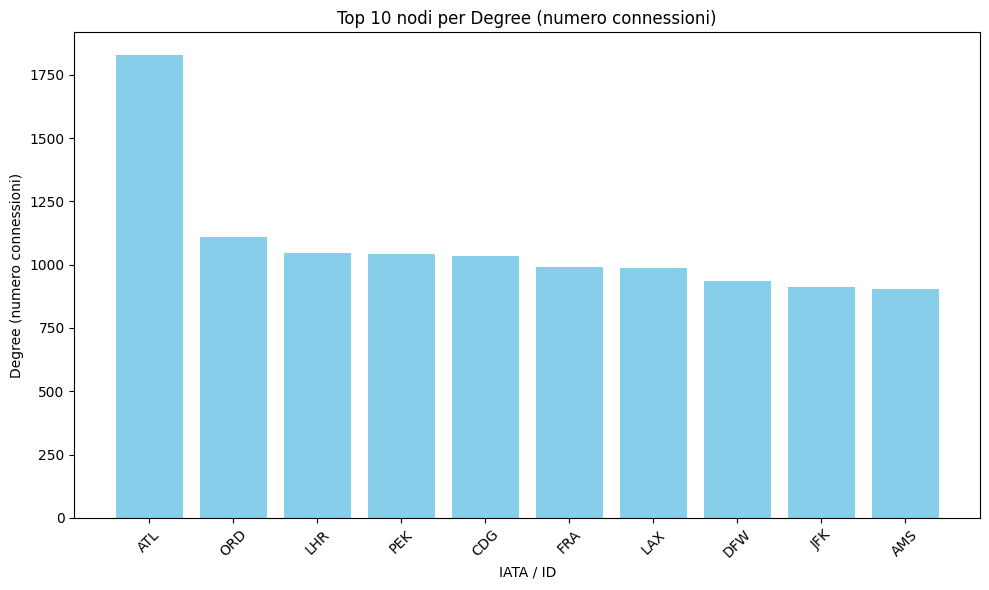

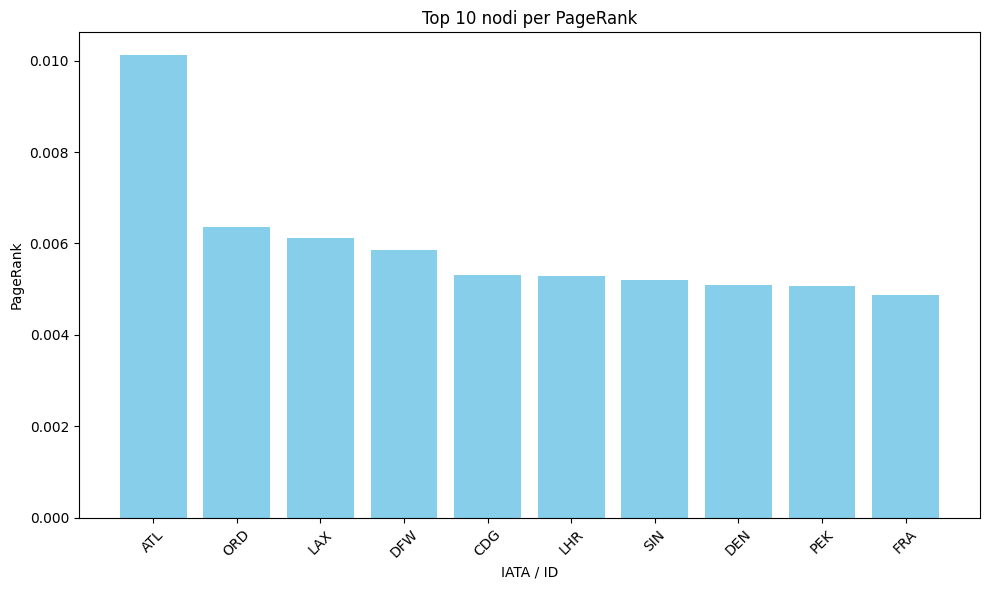

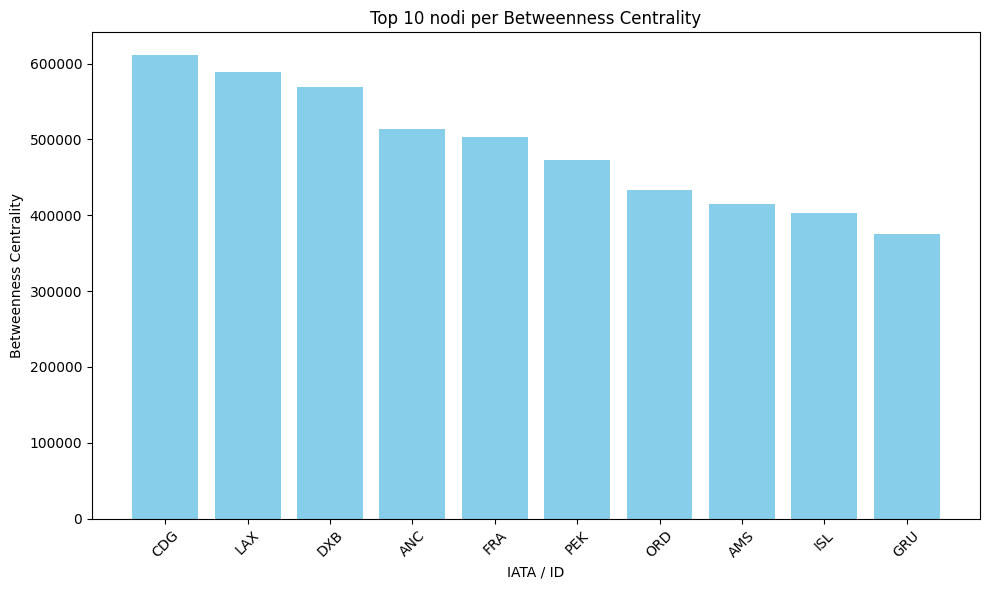

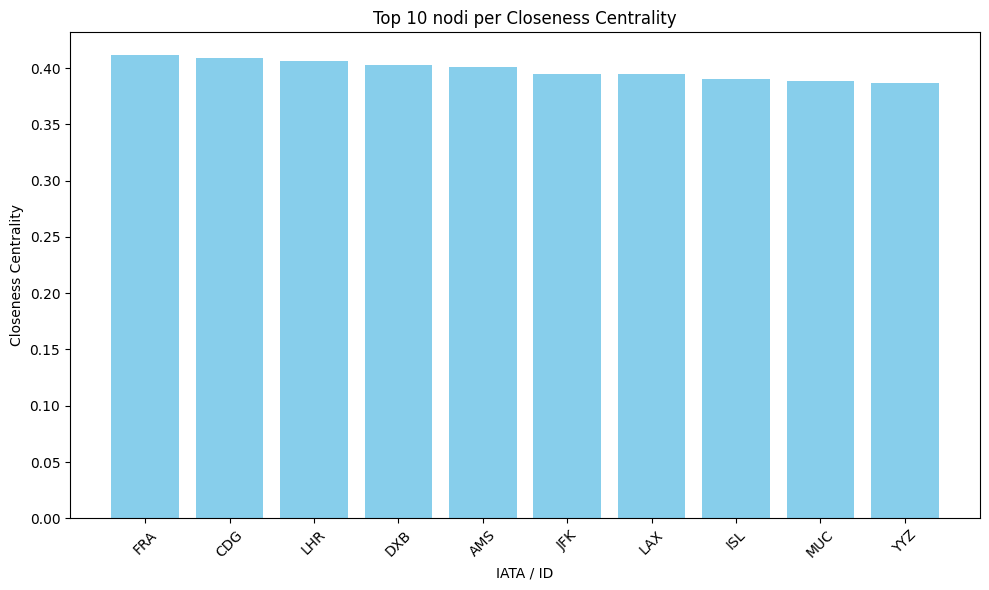

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

routes = pd.read_csv("routes.csv")
airports = pd.read_csv("airports.csv")

id_to_iata = airports.set_index("Airport_ID")["IATA"].to_dict()

G = nx.MultiDiGraph()
G.add_edges_from(zip(routes["Source_ID"], routes["Destination_ID"]))

print("Numero di nodi:", G.number_of_nodes())
print("Numero di archi:", G.number_of_edges())

components = list(nx.connected_components(G.to_undirected()))
print("Numero componenti connesse:", len(components))
print("Dimensione componente principale:", len(max(components, key=len)))

avg_deg = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Grado medio:", avg_deg)

deg_dict = dict(G.degree())
max_deg = max(deg_dict.values())
hub = max(deg_dict, key=deg_dict.get)
print(f"Grado massimo: {max_deg} ({id_to_iata.get(hub, hub)})")

deg = dict(G.degree())
pagerank = nx.pagerank(G, alpha=0.85)
betweenness = nx.betweenness_centrality(G, normalized=False)
closeness = nx.closeness_centrality(G)

def top_centrality(cent_dict, name):
    top = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    ids = [n[0] for n in top]
    vals = [n[1] for n in top]
    labels = [id_to_iata.get(i, str(i)) for i in ids]
    plt.figure(figsize=(10, 6))
    plt.bar(labels, vals, color='skyblue')
    plt.title(f"Top 10 nodi per {name}")
    plt.ylabel(name)
    plt.xlabel("IATA / ID")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

top_centrality(deg, "Degree (numero connessioni)")
top_centrality(pagerank, "PageRank")
top_centrality(betweenness, "Betweenness Centrality")
top_centrality(closeness, "Closeness Centrality") 


I risultati mostrano che il grafo costruito contiene 3.076 aeroporti (nodi) e 65.346 rotte aeree (archi) tra di essi. Il fatto che ci siano 7 componenti connesse indica che la rete non è completamente connessa: esistono 7 gruppi separati di aeroporti. Tuttavia, la componente principale è molto grande e comprende 3.050 nodi, il che significa che la quasi totalità degli aeroporti è parte di una rete connessa. Il grado medio di circa 42,5 indica che, in media, ogni aeroporto ha circa 42 collegamenti diretti con altri aeroporti. L’aeroporto con il grado massimo, Atlanta (codice ATL), ha 1.826 connessioni, identificandolo come un hub molto importante. Inoltre, si è deciso di escludere gli aeroporti isolati, cioè quelli senza connessioni, per concentrarsi sull’analisi della rete effettivamente operativa e connessa.

Ad esempio, Atlanta ha molti collegamenti diretti (alto degree), ma closeness e betweenness misurano il ruolo strategico nel network. Closeness indica quanto un aeroporto è vicino a tutti gli altri via percorsi brevi, mentre betweenness misura quanto spesso un aeroporto è un passaggio obbligato tra altri nodi. Atlanta non è in top 10 in queste metriche perché ci sono aeroporti più centrali o più importanti per collegare diverse parti della rete, non solo per il numero di rotte dirette.
Invece il degree e il PageRank evidenziano Atlanta perché queste metriche premiano gli aeroporti con molti collegamenti diretti e connessi a nodi influenti.

## Research Question 1 – Quali aeroporti sono più centrali nella rete?

Vogliamo identificare gli aeroporti più importanti nella rete di collegamenti aerei, ovvero quelli che risultano maggiormente centrali e quindi più rilevanti per la connettività complessiva del grafo.

Nel dataset, molte rotte sono duplicate perché servite da più compagnie. Anche se il grafo semplificato considera un solo arco per tratta, queste duplicazioni indicano una connessione più forte e significativa tra gli aeroporti, rafforzando indirettamente l’importanza evidenziata da PageRank e Betweenness.

PageRank misura l’importanza complessiva di un aeroporto, tenendo conto non solo del numero di rotte dirette, ma anche dell’influenza degli aeroporti collegati. Aiuta a identificare gli hub principali nella rete.

Betweenness indica quanto un aeroporto funge da ponte, ovvero quanto spesso si trova sui percorsi più brevi tra altri aeroporti, evidenziando nodi strategici per la connettività.

Questo codice crea una proiezione del grafo chiamata 'connectedAirports_1' utilizzando Neo4j Graph Data Science. Seleziona tutti gli aeroporti con almeno una connessione e proietta le rotte tra di essi, aggregando le connessioni multiple in un unico arco ponderato in base al numero di rotte. Questa proiezione permette di analizzare la rete degli aeroporti considerando l’intensità del traffico tra di essi.

In [198]:
query_projection_1 = '''
CALL gds.graph.project.cypher(
  'connectedAirports_1',
  'MATCH (a:Airport)--() RETURN id(a) AS id',
  '
  MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport)
  RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight
  '
);
'''
run_query(query_projection_1)


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 1} for query: "\nCALL gds.graph.project.cypher(\n  'connectedAirports_1',\n  'MATCH (a:Airport)--() RETURN id(a) AS id',\n  '\n  MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport)\n  RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight\n  '\n);\n"


[{'nodeQuery': 'MATCH (a:Airport)--() RETURN id(a) AS id',
  'relationshipQuery': 'MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport)\n  RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight',
  'graphName': 'connectedAirports_1',
  'nodeCount': 3076,
  'relationshipCount': 36023,
  'projectMillis': 168}]

Questo codice esegue l’algoritmo PageRank sulla proiezione del grafo chiamata 'connectedAirports_1', utilizzando il peso delle relazioni per calcolare l’importanza degli aeroporti. L’algoritmo restituisce i dieci aeroporti con il punteggio più alto, ordinati dal più influente al meno influente, identificati tramite il loro codice IATA. I risultati vengono poi memorizzati per eventuali elaborazioni successive.

In [ ]:
query_pagerank_1 = '''
CALL gds.pageRank.stream('connectedAirports_1', {
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).iata AS iata, score
ORDER BY score DESC
LIMIT 10

'''
results_pagerank_1 = run_query(query_pagerank_1)

Top 10 aeroporti per PageRank:
{'iata': 'ATL', 'score': 29.40213028775705}
{'iata': 'ORD', 'score': 18.524223852664857}
{'iata': 'LAX', 'score': 17.779226406571286}
{'iata': 'DFW', 'score': 17.117240396362735}
{'iata': 'CDG', 'score': 15.397717589367069}
{'iata': 'LHR', 'score': 15.332161665805364}
{'iata': 'SIN', 'score': 15.10962548454867}
{'iata': 'DEN', 'score': 14.945841383049316}
{'iata': 'PEK', 'score': 14.753924179181002}
{'iata': 'FRA', 'score': 14.118037219292736}


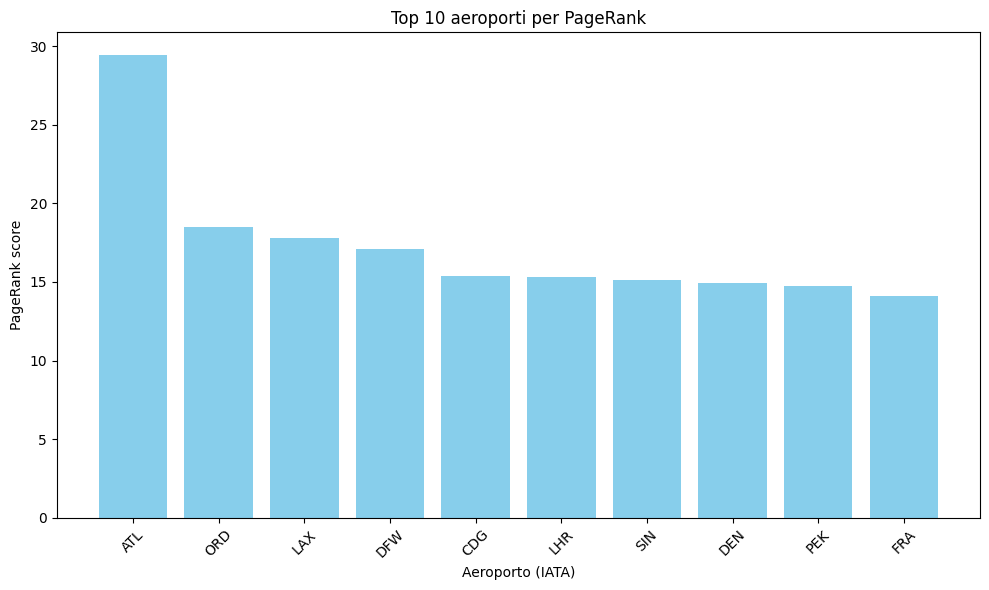

In [ ]:
print("Top 10 aeroporti per PageRank:")
for row in results_pagerank_1:
    print(row)

labels = [row['iata'] for row in results_pagerank_1]
scores = [row['score'] for row in results_pagerank_1]

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color='skyblue')
plt.title('Top 10 aeroporti per PageRank')
plt.xlabel('Aeroporto (IATA)')
plt.ylabel('PageRank score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Per una valutazione più completa dell’influenza degli aeroporti nella rete delle rotte aeree, sono stati confrontati i risultati di PageRank ottenuti con NetworkX (grafo reale con archi multipli) e con Neo4j GDS (grafo proiettato con pesi che rappresentano la frequenza delle rotte). I valori di PageRank sono risultati sostanzialmente uguali nelle due analisi, confermando la coerenza dei risultati sia sul grafo dettagliato che su quello aggregato con pesi, e garantendo una valutazione affidabile dell’importanza degli aeroporti nella rete.

Questo codice calcola la betweenness centrality sulla proiezione del grafo denominata 'connectedAirports_1', tenendo conto del peso delle rotte tra gli aeroporti. L’algoritmo identifica i dieci aeroporti che svolgono il ruolo più importante come punti di passaggio nei percorsi più brevi tra altri aeroporti, ordinandoli in base al punteggio ottenuto. I risultati vengono poi salvati per ulteriori analisi.

In [210]:
query_betweenness_1 = '''
CALL gds.betweenness.stream('connectedAirports_1', {
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).iata AS iata, score
ORDER BY score DESC
LIMIT 10
'''
results_betweenness_1 = run_query(query_betweenness_1)


Top 10 aeroporti per Betweenness Centrality:
{'iata': 'ANC', 'score': 523479.33694246993}
{'iata': 'DOH', 'score': 500174.20894232567}
{'iata': 'HNL', 'score': 459042.5369652957}
{'iata': 'IAH', 'score': 458915.8909397388}
{'iata': 'FRA', 'score': 406117.4946698425}
{'iata': 'CDG', 'score': 382666.3714631184}
{'iata': 'DXB', 'score': 364185.5277127373}
{'iata': 'NRT', 'score': 361606.9826859593}
{'iata': 'YYZ', 'score': 350097.4546526585}
{'iata': 'ISL', 'score': 335614.2916502525}


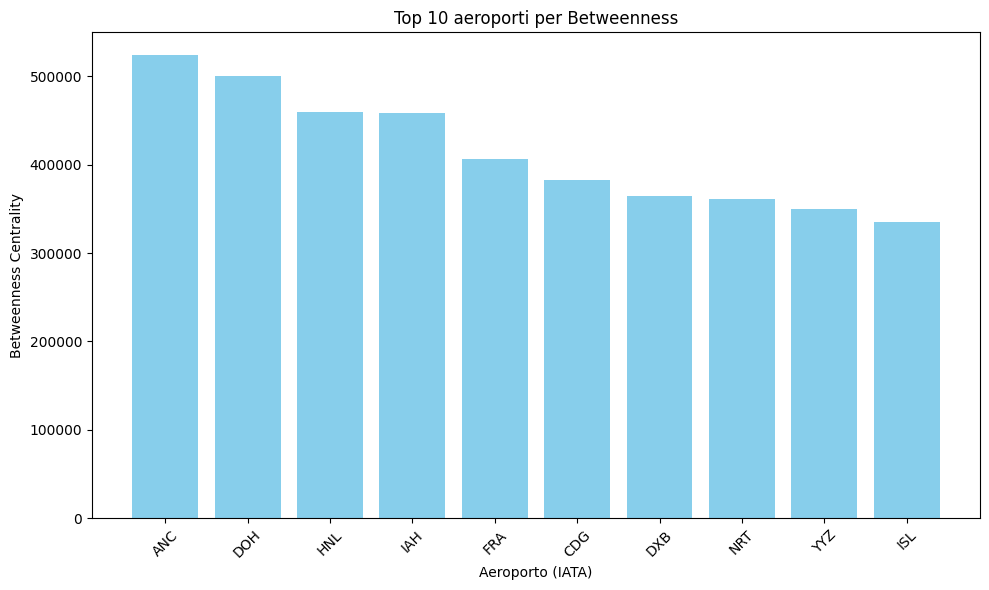

In [211]:

print("Top 10 aeroporti per Betweenness Centrality:")
for row in results_betweenness_1:
    print(row)

labels = [row['iata'] for row in results_betweenness_1]
scores = [row['score'] for row in results_betweenness_1]

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color='skyblue')
plt.title('Top 10 aeroporti per Betweenness')
plt.xlabel('Aeroporto (IATA)')
plt.ylabel('Betweenness Centrality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Per una comprensione più approfondita del ruolo degli aeroporti nella rete, sono stati confrontati i risultati di betweenness centrality ottenuti con NetworkX, che lavora su un grafo reale con archi multipli, e quelli con Neo4j GDS, che utilizza una proiezione aggregata con pesi basati sulla frequenza delle rotte. L’introduzione dei pesi ha influenzato significativamente la valutazione della betweenness, modificando l’importanza attribuita agli aeroporti in base al volume reale di traffico e ai flussi più intensi. Di conseguenza, i risultati differiscono tra i due approcci, riflettendo la maggiore sensibilità di Neo4j GDS alle dinamiche operative della rete, rispetto alla visione topologica più pura offerta da NetworkX.

Questo codice calcola la Freeman's Network Centrality basandosi sui valori di betweenness centrality ottenuti per ogni nodo. Prima crea un DataFrame con i risultati, poi individua il valore massimo di betweenness e conta il numero totale di nodi. Successivamente calcola la somma delle differenze tra il massimo valore e ciascun valore individuale, normalizzandola rispetto alla dimensione della rete. Infine stampa il valore di Freeman's Centrality, che indica quanto la rete è centralizzata attorno ai nodi più importanti.

In [213]:
import numpy as np

df_betweenness_1 = pd.DataFrame(results_betweenness_1)

max_centrality = df_betweenness_1['score'].max()

n = len(df_betweenness_1)

freeman_centrality = sum(max_centrality - df_betweenness_1['score']) / ((n - 1) * (n - 2))

print(f"Freeman's Network Centrality (betweenness): {freeman_centrality}")


Freeman's Network Centrality (betweenness): 15179.07323333751


Questo valore indica un livello di centralizzazione significativo nella rete aeroportuale. Questo significa che la rete non è uniforme ma è fortemente influenzata da alcuni aeroporti che agiscono come nodi cruciali di collegamento — quelli con betweenness centrality più alta, come mostrato nel grafico.

Il grafico evidenzia chiaramente quali sono questi nodi strategici (ad esempio ANC, DOH, HNL), aeroporti che svolgono un ruolo fondamentale nel facilitare i flussi di traffico tra diverse parti della rete, fungendo da "ponti" o snodi di passaggio critici.

In [ ]:
run_query("CALL gds.graph.drop('connectedAirports_1') YIELD graphName, nodeCount, relationshipCount;")

La Betweenness Centrality identifica gli aeroporti che fungono da “nodi ponte” fondamentali per il passaggio tra diverse parti della rete, quindi quelli attraverso cui passano molti percorsi minimi. Gli aeroporti che emergono come più importanti in questo senso, come Anchorage (ANC), Doha (DOH) e Francoforte (FRA), sono spesso snodi strategici per collegare regioni geografiche distanti o isolate, anche se non necessariamente hanno un altissimo numero di rotte dirette.

La PageRank, invece, valuta l’importanza degli aeroporti considerando sia il numero di collegamenti diretti, sia l’importanza degli aeroporti connessi. Gli aeroporti che risultano più rilevanti per questa metrica, come Atlanta (ATL), Chicago (ORD) e Los Angeles (LAX), sono grandi hub con molte rotte dirette e connessi ad altri nodi influenti.

La differenza emerge perché la betweenness premia gli aeroporti cruciali per il flusso globale e la connettività tra regioni diverse, mentre PageRank premia gli aeroporti con elevato numero di connessioni e con forte influenza nella rete. Quindi, mentre Atlanta è un hub con molte rotte dirette (alto PageRank), aeroporti come Anchorage svolgono un ruolo chiave nel collegare diverse zone geografiche, risultando più importanti in termini di betweenness.

## Research question 2 - Esiste una correlazione tra la centralità degli aeroporti e il numero di compagnie aeree?

Questa ricerca indaga se esiste una relazione tra l’importanza degli aeroporti nella rete e il numero di compagnie aeree che vi operano. Per misurare l’importanza degli aeroporti si utilizzano due metriche di centralità: PageRank, che valuta quanto un aeroporto sia influente considerando sia le sue connessioni dirette sia l’importanza degli aeroporti a cui è collegato, e betweenness, che identifica gli aeroporti che fungono da punti di passaggio chiave tra diverse parti della rete. Analizzando la correlazione tra questi indicatori di centralità e il numero di compagnie aeree, si cerca di capire se aeroporti più centrali tendono ad attrarre un maggior numero di operatori, rivelando così come la struttura della rete possa influenzare la distribuzione delle compagnie.

Questo codice crea una proiezione del grafo chiamata 'connectedAirports_2' utilizzando Neo4j Graph Data Science. Seleziona tutti gli aeroporti con almeno una connessione e proietta le rotte tra di essi, aggregando le connessioni multiple in un unico arco ponderato in base al numero di rotte. Questa proiezione permette di analizzare la rete degli aeroporti considerando l’intensità del traffico tra di essi.

In [201]:
query_projection_2 = '''
CALL gds.graph.project.cypher(
  'connectedAirports_2',
  'MATCH (a:Airport)--() RETURN id(a) AS id',
  '
  MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport)
  RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight
  '
);
'''
run_query(query_projection_2)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 1} for query: "\nCALL gds.graph.project.cypher(\n  'connectedAirports_2',\n  'MATCH (a:Airport)--() RETURN id(a) AS id',\n  '\n  MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport)\n  RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight\n  '\n);\n"


[{'nodeQuery': 'MATCH (a:Airport)--() RETURN id(a) AS id',
  'relationshipQuery': 'MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport)\n  RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight',
  'graphName': 'connectedAirports_2',
  'nodeCount': 3076,
  'relationshipCount': 36023,
  'projectMillis': 72}]

Questo codice esegue diverse analisi sul grafo proiettato chiamato 'connectedAirports_2'. Prima calcola il PageRank degli aeroporti, considerando il peso delle rotte per valutare l'importanza di ogni nodo, e ordina i risultati dal valore più alto al più basso. Poi conta quante compagnie aeree operano in ogni aeroporto, raccogliendo queste informazioni per analisi successive. Infine, calcola la betweenness centrality degli aeroporti, sempre tenendo conto del peso delle connessioni, e restituisce i dieci aeroporti con il punteggio più alto, identificando quelli più cruciali come punti di passaggio nella rete.

In [202]:
query_pagerank_2 = '''
CALL gds.pageRank.stream('connectedAirports_2', {
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).iata AS iata, score AS pagerank
ORDER BY pagerank DESC
'''
pagerank_results = run_query(query_pagerank_2)

query_airlines_count = '''
MATCH (a:Airport)
OPTIONAL MATCH (c:Airline)-[:OPERATES]->(a)
RETURN a.iata AS iata, count(DISTINCT c) AS airlineCount
ORDER BY airlineCount DESC
'''
airlines_results = run_query(query_airlines_count)

query_betweenness_2 = '''
CALL gds.betweenness.stream('connectedAirports_2', {
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).iata AS iata, score
ORDER BY score DESC
LIMIT 10
'''
betweenness_results = run_query(query_betweenness_2)



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH (a:Airport)\nOPTIONAL MATCH (c:Airline)-[:OPERATES]->(a)\nRETURN a.iata AS iata, count(DISTINCT c) AS airlineCount\nORDER BY airlineCount DESC\n'


Questo codice unisce i risultati delle analisi di PageRank, betweenness centrality e del numero di compagnie aeree per ogni aeroporto in due DataFrame. Vengono quindi mostrati i primi cinque aeroporti con i valori più alti di PageRank e betweenness insieme al numero di compagnie che vi operano. Successivamente, calcola e stampa la correlazione statistica tra PageRank e numero di compagnie, e tra betweenness e numero di compagnie, per valutare quanto queste metriche di centralità siano legate alla presenza delle compagnie aeree. Infine, fornisce un breve commento interpretativo sulla forza di queste correlazioni.

In [215]:
df_pagerank = pd.DataFrame(pagerank_results)
df_betweenness = pd.DataFrame(betweenness_results) 
df_airlines = pd.DataFrame(airlines_results) 

df_1 = pd.merge(df_pagerank, df_airlines, on='iata', how='left')
df_2 = pd.merge(df_betweenness, df_airlines, on='iata', how='left')

print("Top 5 aeroporti - PageRank e numero di compagnie:")
print(df_1[['iata', 'pagerank', 'airlineCount']].head().to_string(index=False))

print("\nTop 5 aeroporti - Betweenness e numero di compagnie:")
print(df_2[['iata', 'score', 'airlineCount']].head().rename(columns={'score': 'betweenness'}).to_string(index=False))

correlation_1 = df_1['pagerank'].corr(df_1['airlineCount'])
correlation_2 = df_2['score'].corr(df_1['airlineCount'])

print(f"\nCorrelazione tra PageRank e numero di compagnie: {correlation_1:.3f}")
print(f"Correlazione tra Betweenness e numero di compagnie: {correlation_2:.3f}")


Top 5 aeroporti - PageRank e numero di compagnie:
iata  pagerank  airlineCount
 ATL 29.402130            37
 ORD 18.524224            46
 LAX 17.779226            62
 DFW 17.117240            33
 CDG 15.397718           106

Top 5 aeroporti - Betweenness e numero di compagnie:
iata   betweenness  airlineCount
 ANC 523479.336942             9
 DOH 500174.208942            41
 HNL 459042.536965            26
 IAH 458915.890940            31
 FRA 406117.494670           100

Correlazione tra PageRank e numero di compagnie: 0.838
Correlazione tra Betweenness e numero di compagnie: -0.552


In [169]:
run_query("CALL gds.graph.drop('connectedAirports_2') YIELD graphName, nodeCount, relationshipCount;")

[{'graphName': 'connectedAirports_2',
  'nodeCount': 3076,
  'relationshipCount': 36023}]

Il risultato mostra una forte correlazione positiva tra PageRank e il numero di compagnie aeree che operano in un aeroporto, indicando che gli aeroporti più influenti nella rete, cioè quelli collegati a nodi altrettanto importanti, tendono ad avere un maggior numero di compagnie. Al contrario, la correlazione negativa tra betweenness e il numero di compagnie suggerisce che gli aeroporti che fungono da passaggi strategici o snodi di collegamento tra diverse parti della rete non necessariamente ospitano molte compagnie aeree. Questo evidenzia come la posizione di un aeroporto come ponte cruciale nella rete non sia direttamente legata alla quantità di operatori presenti, mostrando ruoli diversi nella struttura della rete aeroportuale.

## Research question 3 - Come si raggruppano gli aeroporti in comunità funzionali nella rete aerea nazionale?

Viene  utilizzato l’algoritmo Louvain applicato sia al grafo reale con archi multipli sia alla proiezione aggregata ponderata con frequenze di rotte. Questo metodo permette di scoprire cluster di aeroporti strettamente collegati non solo dalla presenza di voli, ma anche dalla loro intensità operativa. Le relazioni pesate riflettono il volume dei voli tra aeroporti, consentendo a Louvain di identificare comunità funzionali e geografiche naturali nel network. La corrispondenza dei risultati tra le due rappresentazioni evidenzia come il clustering pesato fornisca una comprensione integrata delle dinamiche operative e della topologia della rete, rivelando sottoreti significative e i loro legami più rilevanti.

Questo codice crea una proiezione del grafo chiamata 'countryAirports' che include solo gli aeroporti situati in Giappone e le rotte aeree tra di essi. Viene selezionato ogni aeroporto giapponese come nodo e tutte le connessioni dirette tra aeroporti all’interno del Giappone come archi. Le rotte multiple tra gli stessi aeroporti vengono aggregate e il numero di voli è utilizzato come peso per ciascuna connessione. Questa proiezione permette di analizzare la rete aerea giapponese tenendo conto sia della presenza sia dell’intensità dei collegamenti tra aeroporti nel paese.

In [219]:
query_projection_3 = '''
CALL gds.graph.project.cypher(
  'countryAirports',
  'MATCH (a:Airport) WHERE a.country = "Japan" RETURN id(a) AS id',
  'MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport) WHERE a1.country = "Japan" AND a2.country = "Japan" RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight'
);
'''
run_query(query_projection_3)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.graph.project.cypher' has been replaced by 'gds.graph.project Cypher projection as an aggregation function')} {position: line: 2, column: 1, offset: 1} for query: '\nCALL gds.graph.project.cypher(\n  \'countryAirports\',\n  \'MATCH (a:Airport) WHERE a.country = "Japan" RETURN id(a) AS id\',\n  \'MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport) WHERE a1.country = "Japan" AND a2.country = "Japan" RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight\'\n);\n'


[{'nodeQuery': 'MATCH (a:Airport) WHERE a.country = "Japan" RETURN id(a) AS id',
  'relationshipQuery': 'MATCH (a1:Airport)-[:FLIGHT]->(a2:Airport) WHERE a1.country = "Japan" AND a2.country = "Japan" RETURN id(a1) AS source, id(a2) AS target, count(*) AS weight',
  'graphName': 'countryAirports',
  'nodeCount': 94,
  'relationshipCount': 350,
  'projectMillis': 34}]

Questo codice esegue l’algoritmo di clustering Louvain sulla proiezione del grafo 'countryAirports', utilizzando i pesi delle rotte per individuare le comunità di aeroporti all’interno della rete giapponese. L’algoritmo assegna a ciascun aeroporto un’etichetta di comunità, che viene salvata come proprietà sui nodi. Successivamente, viene eseguita una query per recuperare gli aeroporti con i rispettivi cluster assegnati, ordinandoli per gruppo e per codice aeroporto. In questo modo si ottiene una suddivisione della rete in cluster funzionali che riflettono le connessioni più forti e frequenti tra gli aeroporti del paese.

In [220]:
query_louvain_3 = '''
CALL gds.louvain.write('countryAirports', {
  relationshipWeightProperty: 'weight',
  writeProperty: 'community'
})
YIELD communityCount, modularity;
'''
run_query(query_louvain_3)

query_clusters_3 = '''
MATCH (a:Airport)
WHERE a.country = "Japan"
RETURN a.iata AS airport, a.community AS cluster
ORDER BY cluster, airport;
'''
clusters = run_query(query_clusters_3)


   airport  cluster
0      MUS        3
1      IWO        4
2      CTS        7
3      FUK        7
4      HIJ        7
5      IBR        7
6      KIJ        7
7      KMQ        7
8      MMJ        7
9      NGO        7
10     NRT        7
11     SDJ        7
12     TOY        7
13     UKB        7
14     YGJ        7
15     OIR       17
16     RIS       18
17     KUM       19
18     TNE       22
19     FUJ       28
20     IKI       28
21     NGS       28
22     TSJ       28
23     OKE       30
24     TKN       31
25     FKJ       32
26     QGU       33
27     OKI       35
28     AOJ       43
29     ASJ       43
30     AXT       43
31     FKS       43
32     GAJ       43
33     HNA       43
34     ITM       43
35     KMI       43
36     KMJ       43
37     MSJ       43
38     NKM       43
39     OIT       43
40     SDS       49
41     HHE       50
42     NJA       55
43     AKJ       58
44     HAC       58
45     HKD       58
46     HND       58
47     HSG       58
48     IWJ       58


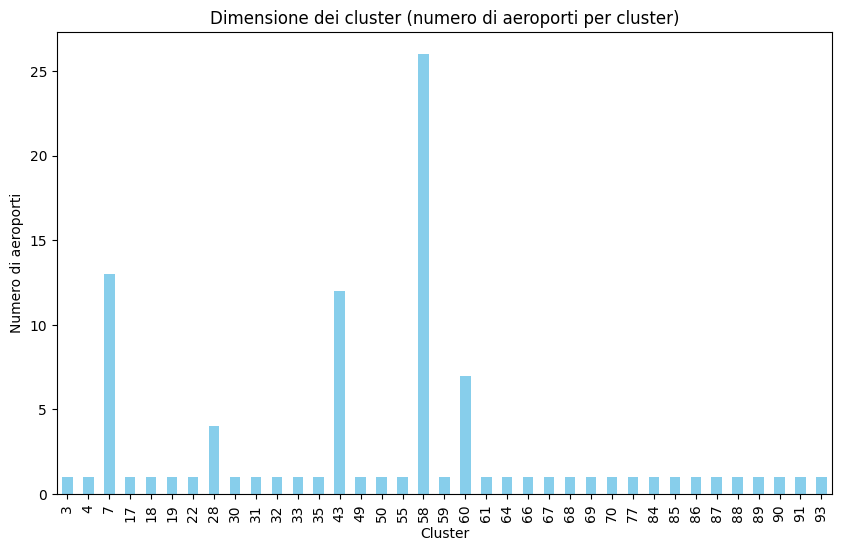

In [ ]:
df_clusters = pd.DataFrame(clusters)
print(df_clusters)

cluster_sizes = df_clusters['cluster'].value_counts().sort_index()

plt.figure(figsize=(10,6))
cluster_sizes.plot(kind='bar', color='skyblue')
plt.title('Dimensione dei cluster (numero di aeroporti per cluster)')
plt.xlabel('Cluster')
plt.ylabel('Numero di aeroporti')
plt.show()

In [218]:
run_query("CALL gds.graph.drop('countryAirports') YIELD graphName, nodeCount, relationshipCount;")

[{'graphName': 'countryAirports', 'nodeCount': 94, 'relationshipCount': 350}]

I risultati dell’analisi sui cluster degli aeroporti giapponesi mostrano come la rete si articoli in gruppi distinti che riflettono realtà operative e geografiche specifiche del paese. Gli aeroporti raggruppati nello stesso cluster condividono forti legami di traffico, servono bacini di utenza comuni o sono collegati da rotte frequenti, evidenziando una suddivisione naturale della rete in moduli coerenti. Questi moduli possono corrispondere a regioni, zone economiche o corridoi di traffico particolarmente attivi, facilitando così l’identificazione di sistemi aeroportuali locali o regionali e la comprensione di come il traffico aereo si distribuisce e si organizza sul territorio giapponese.



Ad esempio, il cluster 58 include un gran numero di aeroporti (~25), tra cui Haneda, uno degli hub più trafficati e connessi, che svolge un ruolo centrale per numerose rotte sia nazionali sia internazionali. Gli aeroporti in questo cluster formano una rete molto integrata, caratterizzata da frequenti collegamenti reciproci, creando una comunità funzionale densa e operativa. Haneda funge da nodo chiave all’interno di questa sottorete, la quale riflette l’efficienza e l’intensità dei collegamenti aerei nella regione.
